Analyzing n-tuples in some databases
--

In [1]:
%matplotlib inline

In [83]:
import requests
resp = requests.get('http://www.gutenberg.org/cache/epub/1342/pg1342.txt')
print resp.text[:200]

﻿The Project Gutenberg EBook of Pride and Prejudice, by Jane Austen

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it aw


In [3]:
text_start_line = 'It is a truth universally acknowledged'
text_end_line = 'End of the Project Gutenberg EBook of Pride and Prejudice, by Jane Austen'

In [4]:
text = resp.text
text = text[text.find(text_start_line):text.find(text_end_line)]

In [5]:
print text[:160]

It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

However little known the feelings or v


In [6]:
print text[-160:]

hey were both ever
sensible of the warmest gratitude towards the persons who, by bringing
her into Derbyshire, had been the means of uniting them.








In [7]:
type(text)

unicode

In [8]:
# Strip out non-alphabetical characters
import re
text = text.lower()
text = re.sub("[^a-z\s]+", "", text)
text = re.sub("\s+", " ", text)

In [9]:
print text[:160]

it is a truth universally acknowledged that a single man in possession of a good fortune must be in want of a wife however little known the feelings or views of


In [10]:
# Probabilities of individual letters
from collections import Counter, OrderedDict
counter = Counter(text)
print counter

Counter({u' ': 121463, u'e': 69366, u't': 46641, u'a': 41681, u'o': 40039, u'i': 37830, u'n': 37687, u'h': 34066, u's': 33109, u'r': 32295, u'd': 22299, u'l': 21592, u'u': 14985, u'm': 14764, u'c': 13460, u'y': 12706, u'w': 12305, u'f': 12000, u'g': 10030, u'b': 9087, u'p': 8224, u'v': 5726, u'k': 3208, u'z': 936, u'j': 871, u'x': 839, u'q': 627})


In [11]:
import string
import pandas as pd
letters = list(string.lowercase) + [' ']
counts = pd.Series(
    index=letters,
    data=[counter[letter] for letter in letters]
)

In [12]:
import numpy as np

In [13]:
print counts

a     41681
b      9087
c     13460
d     22299
e     69366
f     12000
g     10030
h     34066
i     37830
j       871
k      3208
l     21592
m     14764
n     37687
o     40039
p      8224
q       627
r     32295
s     33109
t     46641
u     14985
v      5726
w     12305
x       839
y     12706
z       936
     121463
dtype: int64


In [14]:
import matplotlib
matplotlib.style.use('ggplot')

In [15]:
# Entropy of P1

In [16]:
pdf = counts / np.sum(counts)

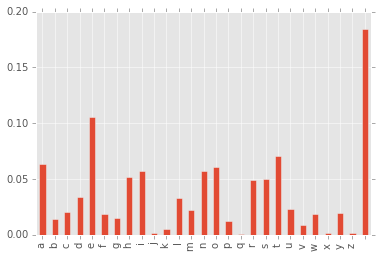

In [17]:
pdf.plot(kind='bar')

In [18]:
H = -np.dot(pdf, np.log2(pdf))
print H

4.09931661652


In [19]:
from scipy.stats import entropy
print entropy(pdf, base=2)

4.09931661652


In [20]:
# P2 -- distribution of letter pairs

In [21]:
digrams = zip(text[:-1], text[1:])

In [22]:
digrams[:10]

[(u'i', u't'),
 (u't', u' '),
 (u' ', u'i'),
 (u'i', u's'),
 (u's', u' '),
 (u' ', u'a'),
 (u'a', u' '),
 (u' ', u't'),
 (u't', u'r'),
 (u'r', u'u')]

In [23]:
counts = Counter(digrams)

In [24]:
counts.most_common(5)

[((u'e', u' '), 21949),
 ((u' ', u't'), 15969),
 ((u'h', u'e'), 14823),
 ((u't', u'h'), 13748),
 ((u'd', u' '), 13739)]

In [25]:
first_letter, second_letter = zip(*counts.keys())
values = counts.values()

In [26]:
p2 = pd.DataFrame({
    'First Letter': first_letter,
    'Second Letter': second_letter,
    'Count': values
}, columns=['First Letter', 'Second Letter', 'Count'])

p2['Count'] /= p2['Count'].sum()

In [27]:
frequency_table = p2.pivot(index='First Letter', columns='Second Letter', values='Count')

In [28]:
frequency_table.loc['a':'f', 'a':'f']

Second Letter,a,b,c,d,e,f
First Letter,,,,,,
a,0.000011,0.002336,0.001695,0.003676,0.000009,0.000705
b,0.000439,0.000011,NaN,0.000002,0.006330,NaN
c,0.002127,0.000002,0.000493,0.000005,0.003771,NaN
d,0.001619,0.000012,0.000002,0.000313,0.003861,0.000038
e,0.004746,0.000081,0.002479,0.008216,0.002873,0.001035
f,0.001196,0.000002,0.000009,0.000009,0.001698,0.000874


In [30]:
frequency_table

Second Letter,,a,b,c,d,e,f,g,h,i,...,q,r,s,t,u,v,w,x,y,z
First Letter,,,,,,,,,,,,,,,,,,,,,
,NaN,0.020513,0.009214,0.007172,0.005778,0.004998,0.006269,0.002753,0.016016,0.012907,...,0.000382,0.003609,0.013341,0.024275,0.001544,0.001326,0.013768,NaN,0.003510,NaN
a,0.003381,0.000011,0.002336,0.001695,0.003676,0.000009,0.000705,0.001281,0.000009,0.002377,...,NaN,0.006289,0.007391,0.008574,0.000772,0.002070,0.000509,0.000005,0.001809,0.000035
b,0.000008,0.000439,0.000011,NaN,0.000002,0.006330,NaN,NaN,0.000011,0.000648,...,NaN,0.000489,0.000234,0.000161,0.001681,0.000002,NaN,NaN,0.001014,NaN
c,0.000093,0.002127,0.000002,0.000493,0.000005,0.003771,NaN,NaN,0.003422,0.000795,...,0.000152,0.000482,0.000011,0.001944,0.000555,NaN,NaN,NaN,0.000774,NaN
d,0.020885,0.001619,0.000012,0.000002,0.000313,0.003861,0.000038,0.000185,0.000018,0.002913,...,0.000002,0.000362,0.000648,0.000032,0.000348,0.000152,0.000033,NaN,0.000617,NaN
e,0.033366,0.004746,0.000081,0.002479,0.008216,0.002873,0.001035,0.000493,0.000234,0.001634,...,0.000284,0.017203,0.005518,0.003949,0.000029,0.002159,0.000576,0.001105,0.001771,NaN
f,0.007052,0.001196,0.000002,0.000009,0.000009,0.001698,0.000874,0.000003,0.000012,0.001253,...,NaN,0.001275,0.000011,0.000645,0.000534,NaN,0.000003,NaN,0.000065,NaN
g,0.005412,0.001110,0.000135,0.000002,0.000006,0.001964,0.000002,0.000053,0.002288,0.000821,...,NaN,0.001003,0.000345,0.000064,0.000220,NaN,0.000002,NaN,0.000036,NaN
h,0.006245,0.009580,0.000081,NaN,0.000014,0.022533,0.000017,NaN,0.000006,0.006824,...,NaN,0.000242,0.000109,0.001400,0.000415,NaN,0.000006,NaN,0.000114,NaN


In [31]:
import matplotlib.pyplot as plt

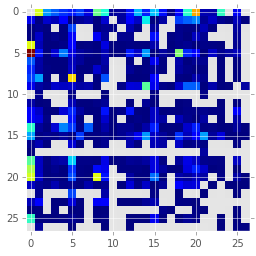

In [32]:
plt.imshow(frequency_table, interpolation='none')

In [43]:
conditional_pdf = frequency_table.div(frequency_table.sum(axis=1), axis='index')
conditional_pdf = conditional_pdf.fillna(0)

In [40]:
frequency_table.sum(axis=1)

First Letter
                0.184639
a               0.063361
b               0.013813
c               0.020461
d               0.033898
e               0.105446
f               0.018242
g               0.015247
h               0.051785
i               0.057507
j               0.001324
k               0.004877
l               0.032823
m               0.022443
n               0.057289
o               0.060865
p               0.012502
q               0.000953
r               0.049093
s               0.050330
t               0.070901
u               0.022779
v               0.008704
w               0.018705
x               0.001275
y               0.019315
z               0.001423
dtype: float64

In [45]:
conditional_pdf.loc['q']

Second Letter
                 0.001595
a                0.000000
b                0.000000
c                0.000000
d                0.000000
e                0.000000
f                0.000000
g                0.000000
h                0.000000
i                0.000000
j                0.000000
k                0.000000
l                0.000000
m                0.000000
n                0.000000
o                0.000000
p                0.000000
q                0.000000
r                0.000000
s                0.000000
t                0.000000
u                0.998405
v                0.000000
w                0.000000
x                0.000000
y                0.000000
z                0.000000
Name: q, dtype: float64

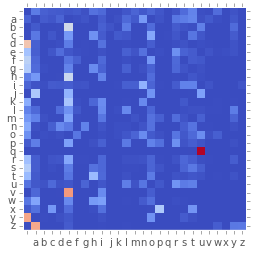

In [48]:
plt.imshow(conditional_pdf, interpolation='none', cmap='coolwarm')
labels = conditional_pdf.index
_ = plt.xticks(range(len(labels)), labels)
_ = plt.yticks(range(len(labels)), labels)
plt.grid(False)

In [333]:
conditional_pdf.loc['q']

Second Letter
                 0.000008
a                0.000000
b                0.000000
c                0.000000
d                0.000000
e                0.000000
f                0.000000
g                0.000000
h                0.000000
i                0.000000
j                0.000000
k                0.000000
l                0.000000
m                0.000000
n                0.000000
o                0.000000
p                0.000000
q                0.000000
r                0.000000
s                0.000000
t                0.000000
u                0.041775
v                0.000000
w                0.000000
x                0.000000
y                0.000000
z                0.000000
Name: q, dtype: float64

In [49]:
from itertools import islice

def find_words(substring):
    substring = substring.replace(' ', '\s')
    regexp = '(?P<word>\w*{}\w*)'.format(substring)
    for match in re.finditer(regexp, text):
        yield match.groupdict()['word']

In [50]:
list(islice(find_words('qu'), 10))

[u'quickness',
 u'quick',
 u'acquainted',
 u'acquaintance',
 u'quite',
 u'acquaintance',
 u'acquaintance',
 u'acquaintances',
 u'questions',
 u'quite']

In [51]:
list(find_words('q '))

[u'esq to']

In [52]:
# Entropies
entropy(p2['Count'], base=2)

7.403641062742893

In [53]:
for letter in letters:
    print letter, entropy(conditional_pdf.loc[letter], base=2)

a 3.75237595884
b 2.63709565337
c 3.17504838207
d 2.12901650048
e 3.40444439894
f 2.75621615866
g 2.97999377189
h 2.34247777979
i 3.59182224702
j 1.96442512306
k 2.50156596352
l 3.401429211
m 3.24958166229
n 3.39503192962
o 3.6265805787
p 3.25765761866
q 0.0171194028502
r 3.28149479231
s 3.05496624835
t 2.84164943442
u 3.5664755349
v 1.18507594698
w 2.79183003388
x 2.58210051874
y 1.48291071751
z 1.4703005486
  4.12135865559


In [54]:
conditional_pdf.loc['x']

Second Letter
                 0.032181
a                0.082241
b                0.000000
c                0.185936
d                0.000000
e                0.075089
f                0.001192
g                0.000000
h                0.008343
i                0.084625
j                0.000000
k                0.000000
l                0.000000
m                0.000000
n                0.000000
o                0.000000
p                0.348033
q                0.001192
r                0.000000
s                0.000000
t                0.176400
u                0.003576
v                0.000000
w                0.000000
x                0.000000
y                0.001192
z                0.000000
Name: x, dtype: float64

In [55]:
# Higher-order digrams
trigrams = zip(*[text[n:-3+n] for n in range(3)])
quadgrams = zip(*[text[n:-4+n] for n in range(4)])

In [56]:
for quadgram in quadgrams[:10]:
    print ''.join(quadgram)

it i
t is
 is 
is a
s a 
 a t
a tr
 tru
trut
ruth


In [57]:
counts = Counter(quadgrams)

In [58]:
len(counts)

16280

In [59]:
[(''.join(letters), count) for letters, count in counts.most_common(5)]

[(u' the', 6510),
 (u'the ', 4332),
 (u' to ', 4127),
 (u'and ', 3749),
 (u' of ', 3598)]

In [60]:
num_trigrams = len(Counter(trigrams))

In [61]:
trigram_counter = Counter(trigrams)
trigram_strings = [''.join(trigram) for trigram in trigram_counter]
trigram_counts = trigram_counter.values()
p3 = pd.Series(index=trigram_strings, data=trigram_counts)
p3 /= p3.sum()

In [62]:
p3

f s    0.000442
emy    0.000002
g u    0.000046
w w    0.000160
tan    0.000538
tth    0.000006
urc    0.000062
bel    0.000266
isp    0.000141
gna    0.000024
iti    0.000263
som    0.000603
sau    0.000002
yle    0.000015
chl    0.000005
...
bag    0.000002
vab    0.000006
odw    0.000005
eva    0.000043
idl    0.000018
ino    0.000006
ame    0.000461
epi    0.000029
erd    0.000023
rsi    0.000026
xte    0.000033
his    0.002651
vot    0.000008
gov    0.000017
 st    0.000787
Length: 4061, dtype: float64

In [72]:
quadgram_counter = Counter(quadgrams)
quadgram_counts = quadgram_counter.values()

_p4_data = np.zeros((len(p3), len(letters)), dtype=int)
for n, trigram in enumerate(p3.index):
    for i, letter in enumerate(letters):
        index = tuple(trigram + letter)
        _p4_data[n, i] = quadgram_counter[index]

p4 = pd.DataFrame(
    _p4_data,
    index=p3.index,
    columns=letters
)
#p4 /= _p4_data.sum()

In [74]:
quadgram_counter['the ']

0

In [73]:
p4.loc['the']

     4332
o       0
f       0
     4332
Name: the, dtype: int64

In [64]:
p4.sum(axis=1)

f s    0.000203
emy    0.000007
g u    0.000000
w w    0.000017
tan    0.000000
tth    0.000003
urc    0.000000
bel    0.000054
isp    0.000159
gna    0.000000
iti    0.000251
som    0.000027
sau    0.000000
yle    0.000058
chl    0.000000
...
bag    0.000000
vab    0.000000
odw    0.000000
eva    0.000000
idl    0.000000
ino    0.000010
ame    0.001675
epi    0.000000
erd    0.000000
rsi    0.000014
xte    0.000000
his    0.011642
vot    0.000000
gov    0.000000
 st    0.000210
Length: 4061, dtype: float64

In [65]:
conditional_pdf4 = p4
conditional_pdf4 = p4.div(p4.sum(axis=1), axis='index')

In [70]:
p4.loc['the']

     0.014687
o    0.000000
f    0.000000
     0.014687
Name: the, dtype: float64

In [66]:
conditional_pdf4.loc['the']

     0.5
o    0.0
f    0.0
     0.5
Name: the, dtype: float64

In [67]:
import numpy

In [68]:
def sample(start, n=1000):
    for _ in range(n):
        nextchar = numpy.random.choice(conditional_pdf4.columns, p=conditional_pdf4.loc[start])
        start = (start + nextchar)[-3:]
        yield nextchar

In [69]:
''.join(sample('the'))

u' of foo foo foo of foo foo foo foo foo of of foo of foo foo foo foo foo foo off foo foo foo off foo of foo of of of foo foo foo foo foo foo foo foo foo of foo foo foo foo foo foo foo of of of foo of foo foo foo foo of of of foo foo of foo of of of of foo foo foo foo foo foo foo of foo foo foo foo of of foo foo foo of foo foo foo foo foo foo foo foo foo of of of foo foo of foo foo of of of of of of of foo foo of of foo foo foo foo foo of foo foo foo foo foo foo of of off foo foo foo foo foo foo foo foo foo foo of of of foo of foo of of foo foo foo foo foo foo of foo foo foo foo foo of foo foo foo foo foo of of foo foo foo of foo foo foo foo foo foo of foo foo foo foo foo foo of of foo foo foo of of of foo foo foo foo of foo foo of foo foo of foo of foo foo of of foo foo foo foo foo foo foo foo of of of foo foo of foo foo of foo foo of of of of foo foo foo of of of foo foo of foo of of of foo foo foo of foo foo of foo foo of of foo foo of of foo foo foo foo foo foo foo foo foo foo foo 

[1000]

In [137]:
# Word boundaries!

In [75]:
words = text.split()
text_nospaces = ''.join(words)
word_lengths = np.array([len(word) for word in words])
word_boundaries = np.cumsum(word_lengths)
print text_nospaces[:80]
print word_boundaries[:10]

start_word_mask = np.zeros(len(text_nospaces), dtype=bool)
start_word_mask[word_boundaries[:-1]] = True
start_word_mask[0] = True

print start_word_mask[:20]

itisatruthuniversallyacknowledgedthatasinglemaninpossessionofagoodfortunemustbei
[ 2  4  5 10 21 33 37 38 44 47]
[ True False  True False  True  True False False False False  True False
 False False False False False False False False]


In [76]:
truncate_length = 1000
text = text_nospaces[:truncate_length]
energy = np.zeros(truncate_length, dtype=float)




In [77]:
digrams = [''.join(letters) for letters in zip(text[:-1], text[1:])]
quadgrams = [''.join(letters) for letters in zip(*[text[n:-4+n] for n in range(4)])]
digram_counter = Counter(digrams)
quadgram_counter = Counter(quadgrams)

In [78]:
for n in range(truncate_length):
    if n < 2 or n > truncate_length - 3:
        continue
    before, after = text[n-2:n], text[n:n+2]
    span = text[n-2:n+2]
    
    energy[n] = float(quadgram_counter[span]) / (digram_counter[before] * digram_counter[after])

energy *= sum(digram_counter.values()) ** 2 / float(sum(quadgram_counter.values()))   
energy = np.log2(energy)

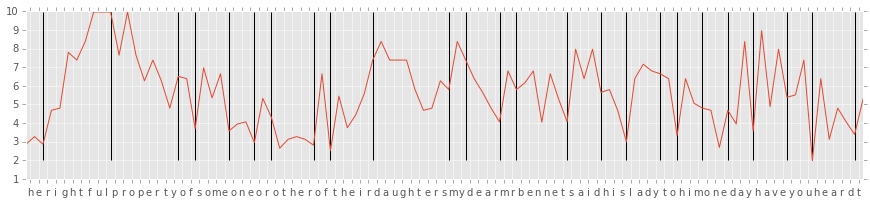

In [80]:
plot_start, plot_end = 250, 350

energy_start = max(plot_start, 2)
energy_end = min(plot_end, len(energy) - 2)
energy_range = energy[energy_start:energy_end]
energy_min, energy_max = np.min(energy_range), np.max(energy_range)

fig = plt.figure(figsize=(15, 3), dpi=80)
ax = fig.add_subplot(111)

ax.xaxis.set_ticks(range(plot_start, plot_end))
ax.xaxis.set_ticklabels(text[plot_start:plot_end])

r = np.arange(plot_start, plot_end)
boundary_locations = r[start_word_mask[plot_start:plot_end]]
ax.vlines(boundary_locations -0.5,energy_min, energy_max)

ax.plot(-0.5 + np.arange(energy_start, energy_end), energy_range)


fig.show()

array([-5.,  5.])

Object `ax.hxlines` not found.
